In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from pytorch_grad_cam import CAM
from torch import nn
from torchvision.transforms import transforms

from solarnet.lib.visualization import SaliencyMap, Weights
from solarnet.lib.visualization.other_utils import run_vis_plot, subplot, tensor2img
from solarnet.lib.visualization.utils import NormalizeInverse, module2traced
from solarnet.models.baseline import CNN

## Model visualization
### Load some images to visualize

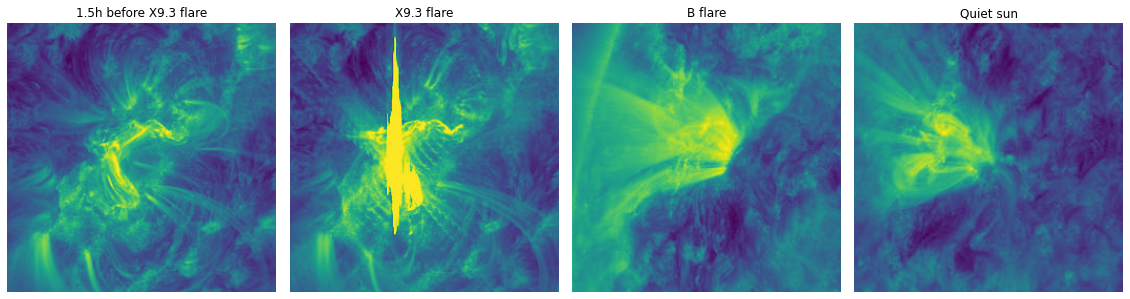

In [2]:
base_path = Path('../data/sdo-benchmark/test')
# base_path = Path('E:/data/sdobenchmark/test')
images_paths = [
    (base_path / '12673/2017_09_06_12_09_59_0/2017-09-06T103959__171.jpg', '1.5h before X9.3 flare'),
    (base_path / '12673/2017_09_06_12_09_59_0/2017-09-06T115959__171.jpg', 'X9.3 flare'),
    (base_path / '12650/2017_04_11_03_01_59_0/2017-04-10T220159__171.jpg', 'B flare'),
    (base_path / '12654/2017_04_29_12_00_00_0/2017-04-29T070000__171.jpg', 'Quiet sun'),
]
images_with_text = list(map(lambda x: (Image.open(x[0]), x[1]), images_paths))
images = [i[0] for i in images_with_text]

def grid(images, width=20, height=6):
    plt.figure(figsize=(width, height))
    plt.subplots_adjust(wspace=0.05)
    plt.subplots_adjust(hspace=0.2)

    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(image[1])

    plt.show()

grid(images_with_text)

### Load model

In [3]:
model_path = Path("../models/binary/")
model = CNN.load_from_checkpoint(str(model_path / "model.ckpt"))

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(256),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ])

tensor = transform(images[0]).unsqueeze(0)

model_traced = module2traced(model, tensor)
print(f"Model:")
for i, layer in enumerate(model_traced):
    print(i, layer)


Model:
0 Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
1 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
3 ReLU()
4 Dropout2d(p=0.1, inplace=False)
5 Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
6 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
7 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
8 ReLU()
9 Dropout2d(p=0.1, inplace=False)
10 Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
11 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
12 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
13 ReLU()
14 Dropout2d(p=0.1, inplace=False)
15 Flatten(start_dim=1, end_dim=-1)
16 Linear(in_features=64, out_features=16, bias=True)
17 ReLU()
18 Dropout2d(p=0.2, inplace=False)
19 Linear(in_f

### Weights visualization

Weight shape: torch.Size([1, 86, 86])
Weight shape: torch.Size([1, 43, 43])
Weight shape: torch.Size([1, 43, 43])
Weight shape: torch.Size([1, 43, 43])
Weight shape: torch.Size([1, 15, 15])
Weight shape: torch.Size([1, 7, 7])


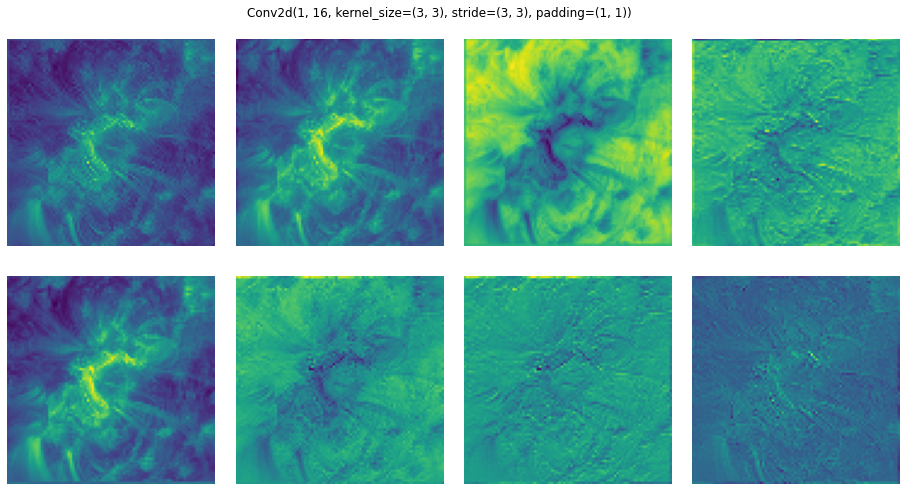

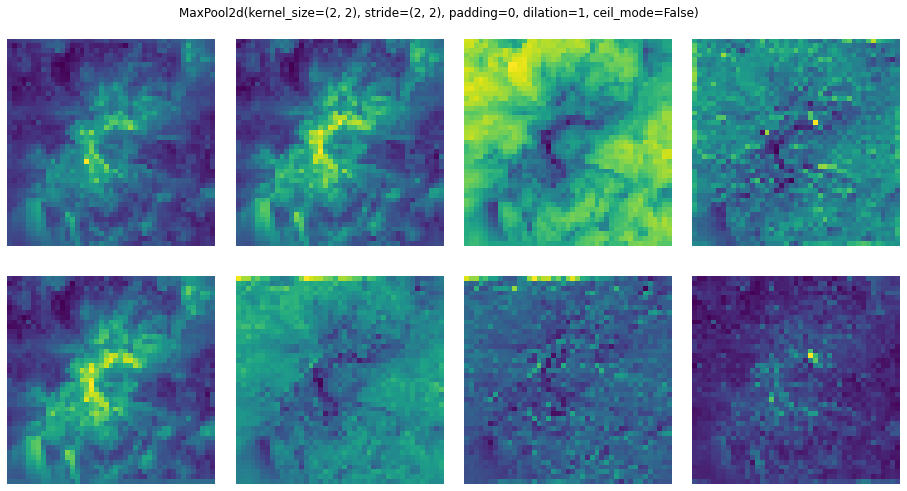

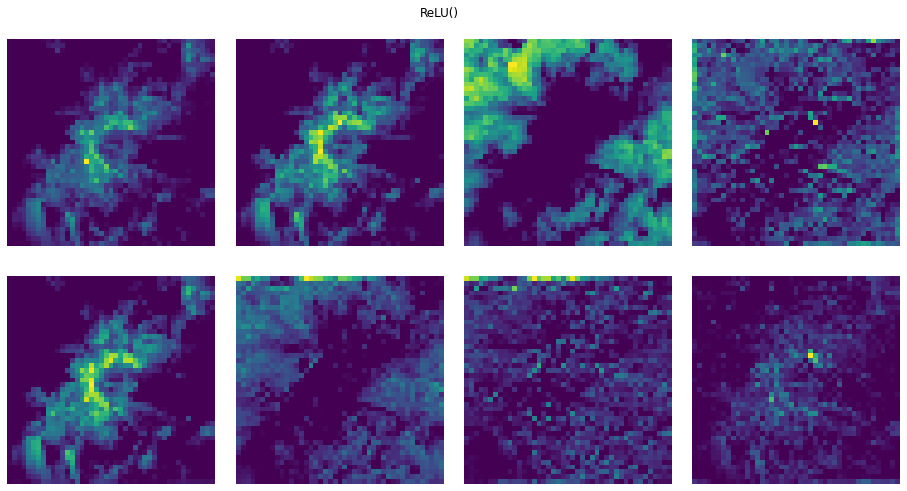

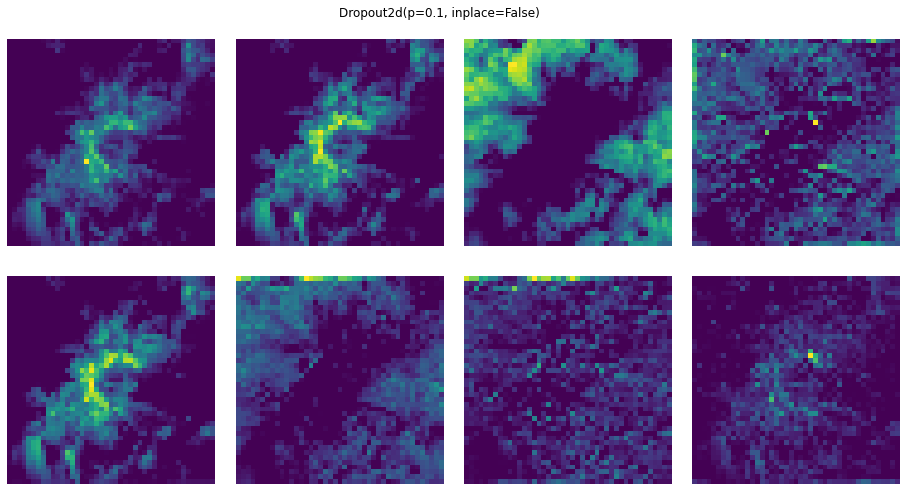

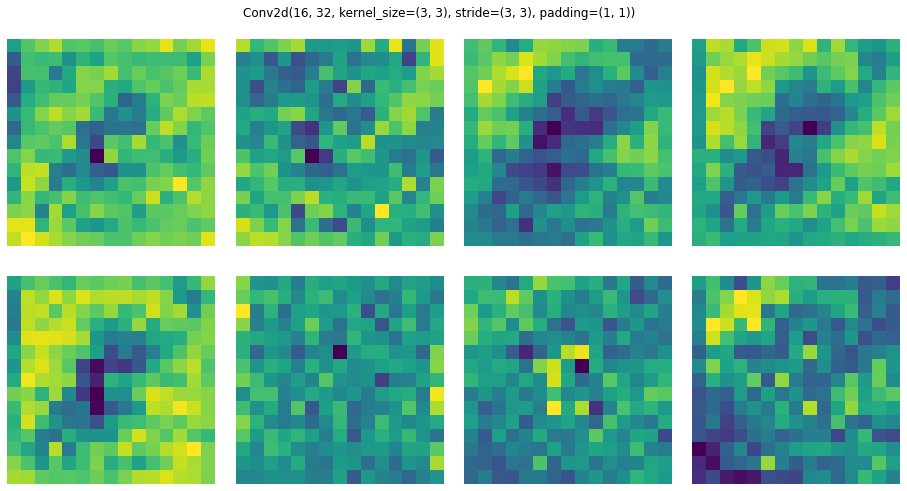

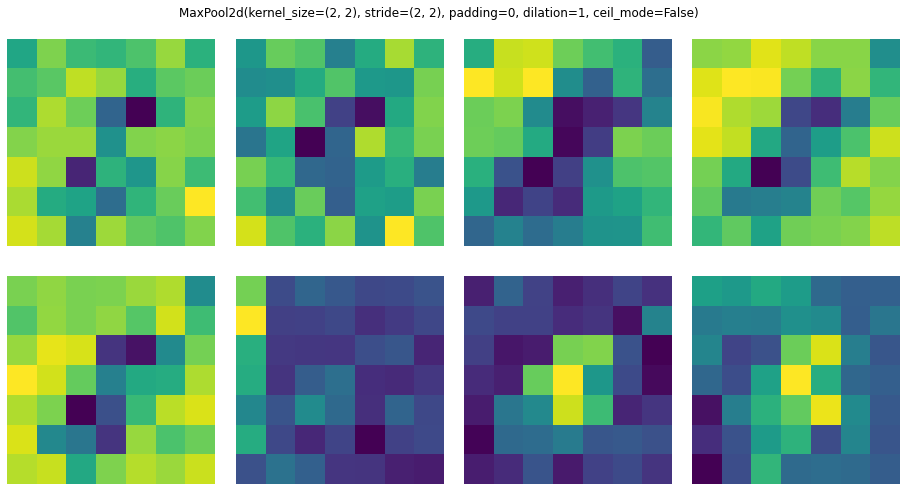

In [4]:
vis = Weights(model, device)
plt.rcParams["figure.figsize"]= 16,8

for layer_id in [0,2,3,4,5,7]:
    layer = model_traced[layer_id]
    run_vis_plot(vis, tensor, layer, ncols=4, nrows=2)

### Saliency map

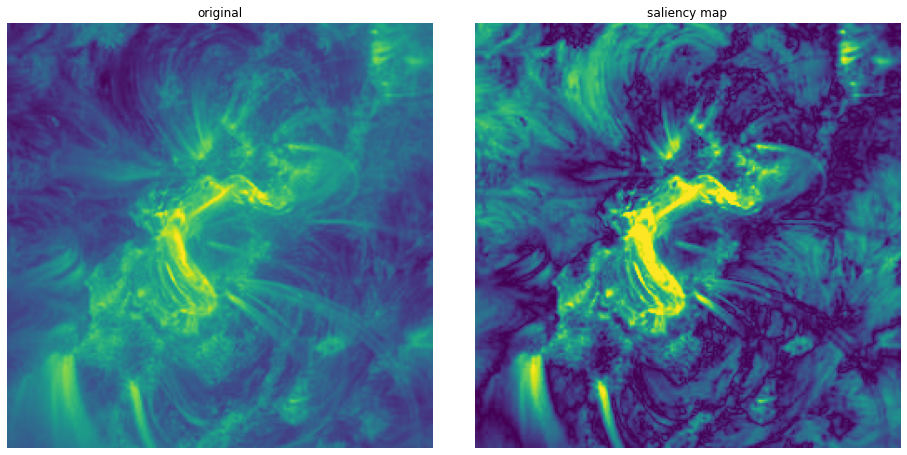

In [5]:
layer_id = 5

image_net_postprocessing = transforms.Compose([NormalizeInverse(mean=[0.5], std=[0.5])])

model.eval()
model = model.to(device)
vis = SaliencyMap(layer_id, model, device)

out, info = vis(tensor, model_traced[layer_id], target_class=0)  # , guide=True, target_class=0)

subplot([image_net_postprocessing(tensor), out],
        rows_titles=['original', 'saliency map'],
        parse=tensor2img,
        nrows=1, ncols=2)

### Grad cam

c:\code\master\solarnet\venv\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


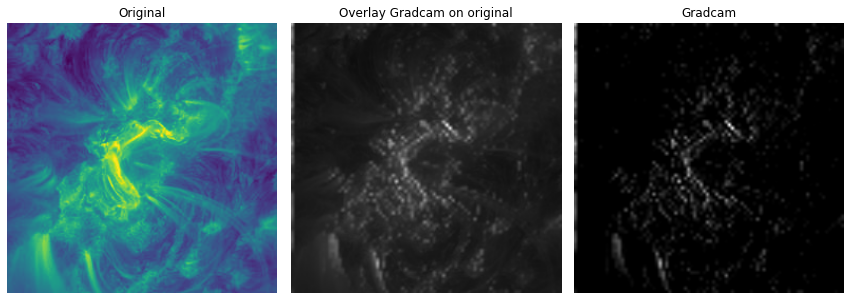

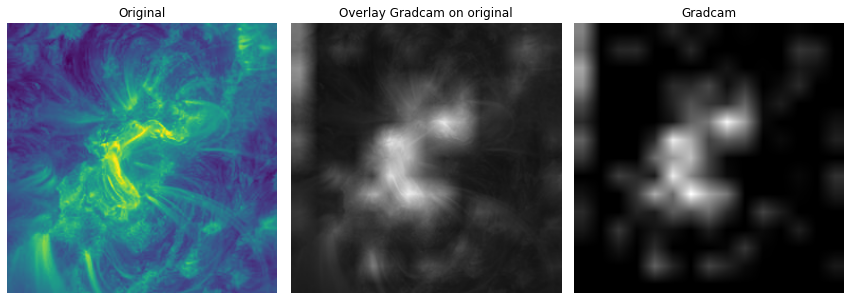

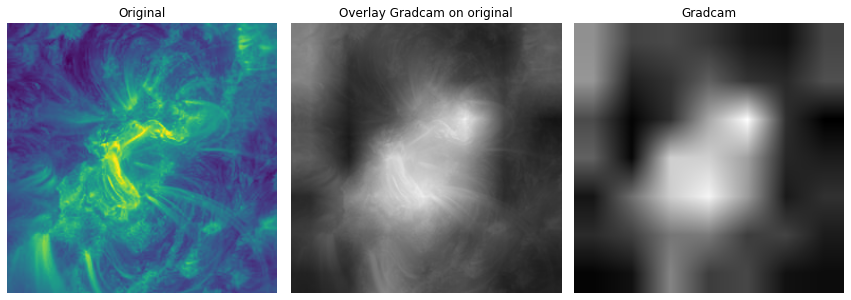

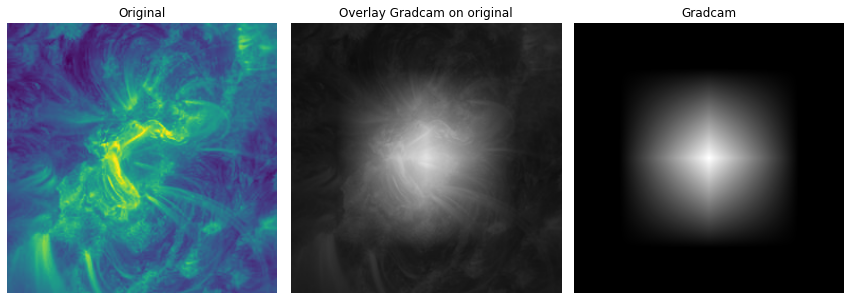

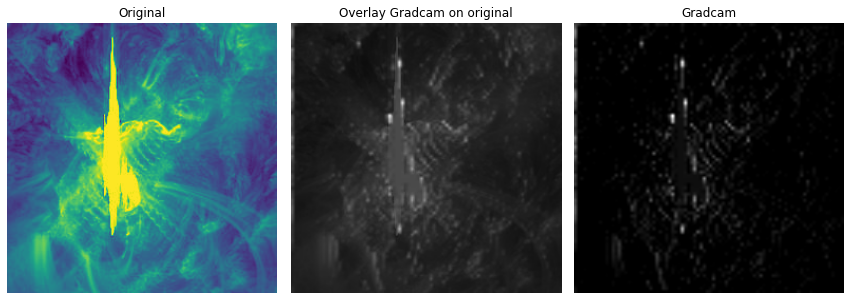

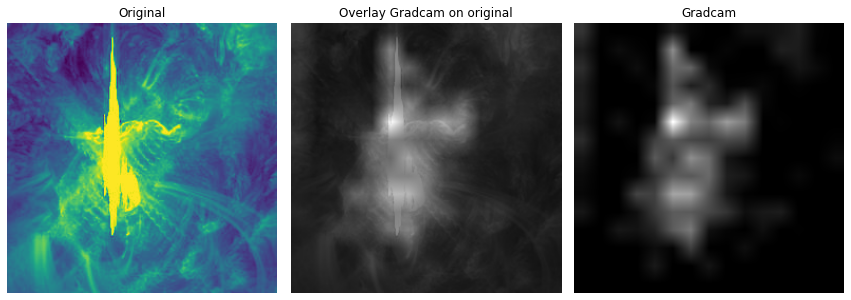

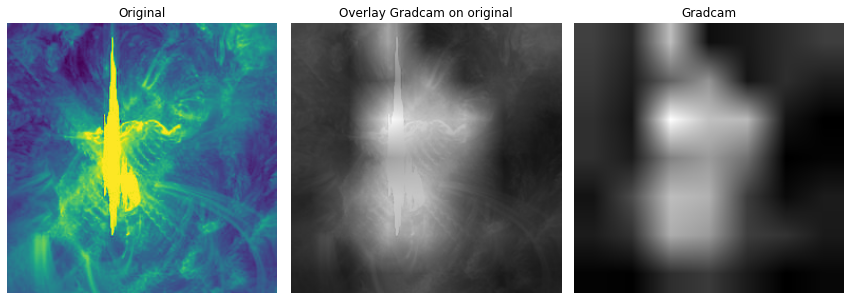

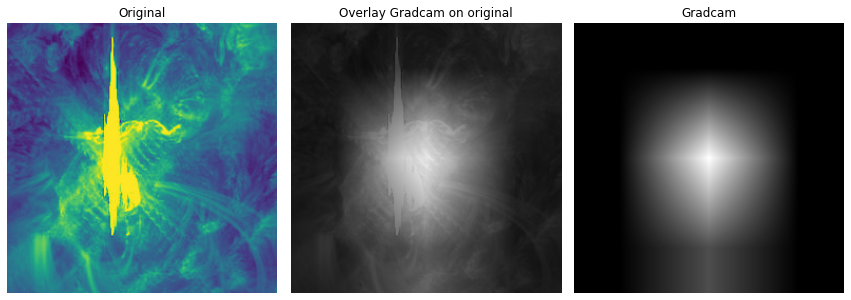

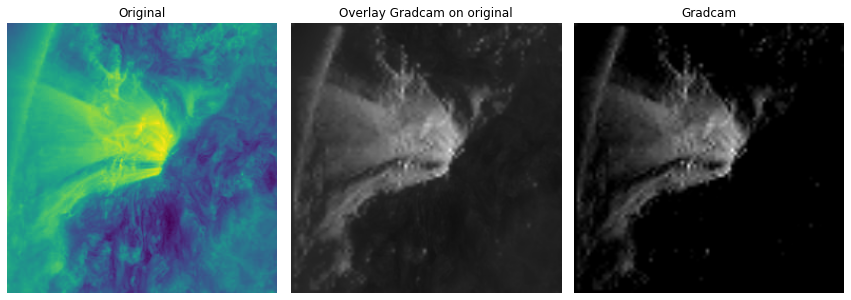

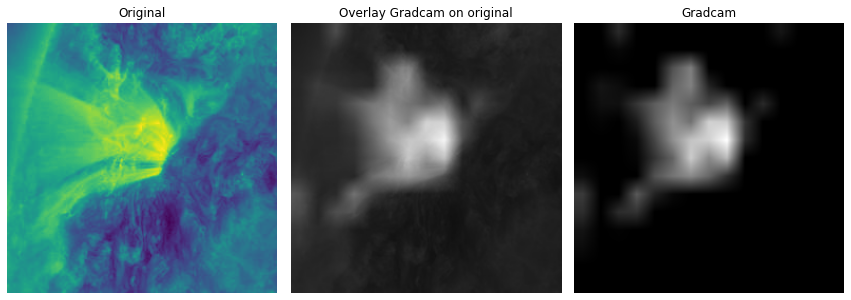

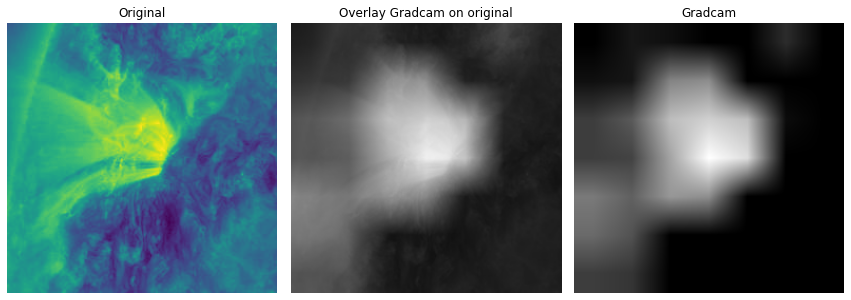

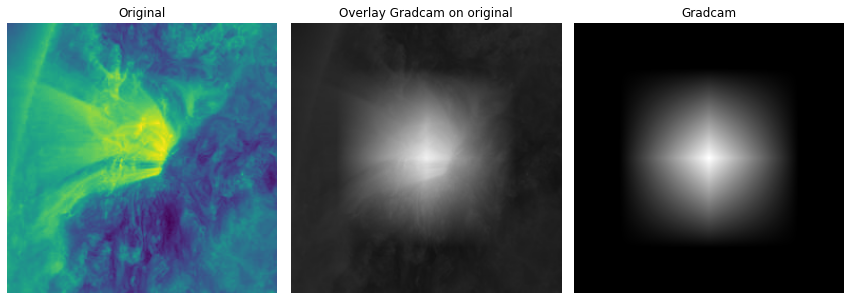

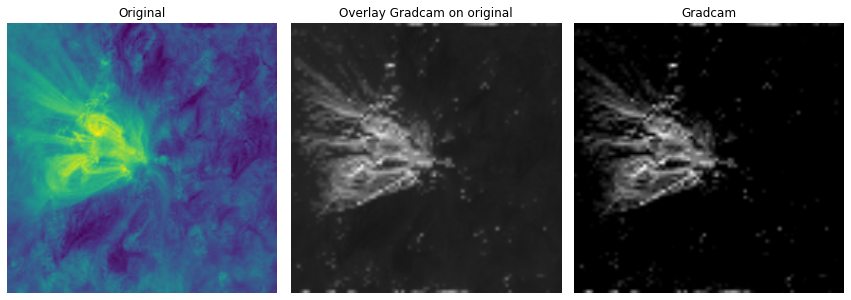

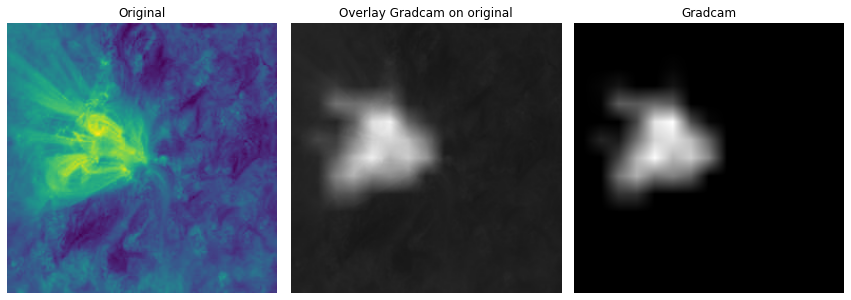

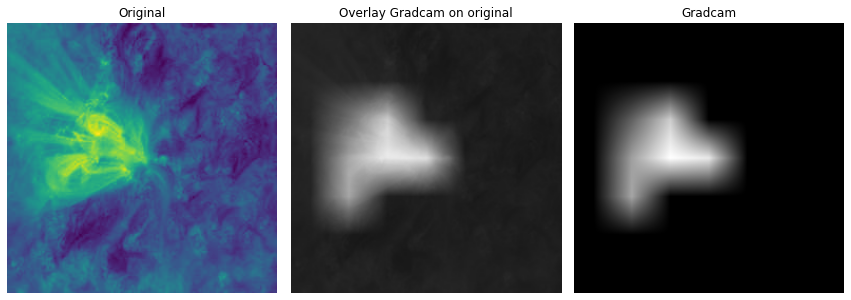

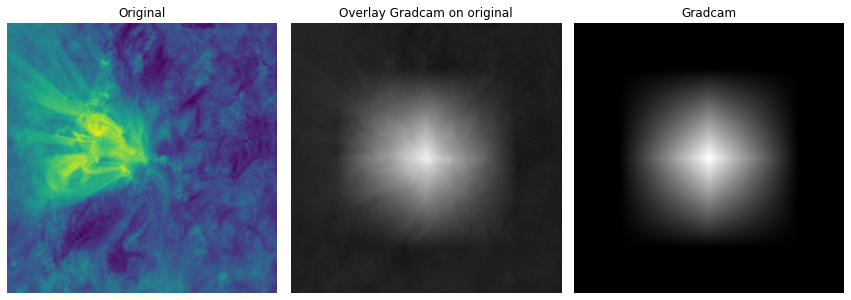

In [6]:
image_id = 2
class_id = 1
layer_id = 6
method = "gradcam"  # Can be gradcam/gradcam++/scorecam

for image_id in [0,1,2,3]:
    for layer_id in [1,6,8,10]:
        tensor = transform(images[image_id]).unsqueeze(0)
        target_layer = model_traced[layer_id]
        cam = CAM(model=model,  target_layer=target_layer, use_cuda=False)
        grayscale_cam = cam(input_tensor=tensor, target_category=class_id, method=method)

        overlay = Image.fromarray((grayscale_cam*255).astype(np.uint8)).convert("RGBA")
        blend = Image.blend(images[image_id].convert("RGBA"), overlay,alpha=0.75)

        grid([
            (images[image_id], "Original"),
            (blend, "Overlay Gradcam on original"),
            (overlay, "Gradcam")
        ], width=15)

### Other method

3
[Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1)), Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))]


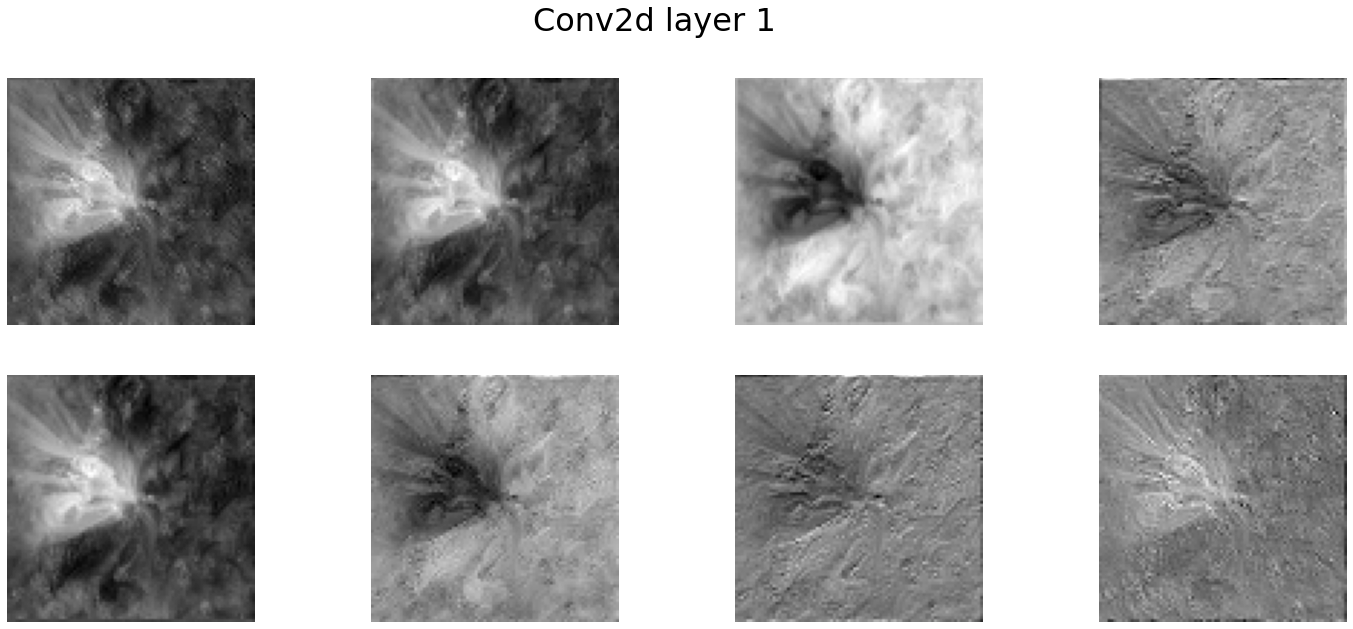

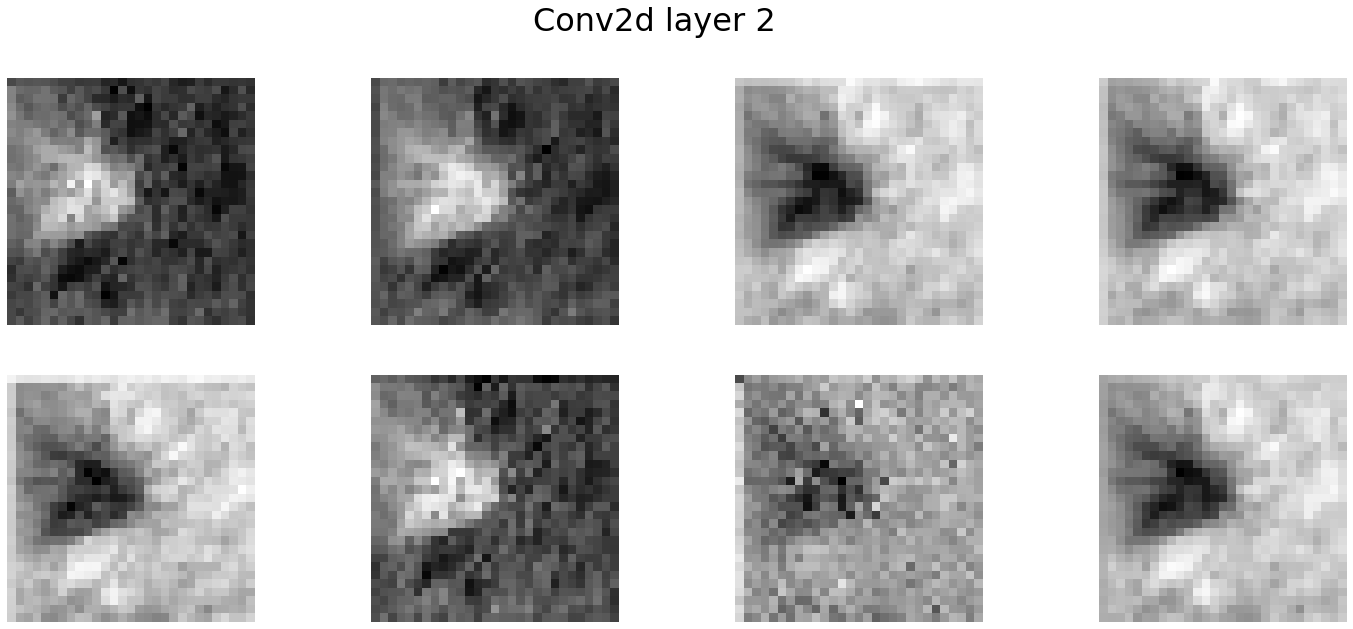

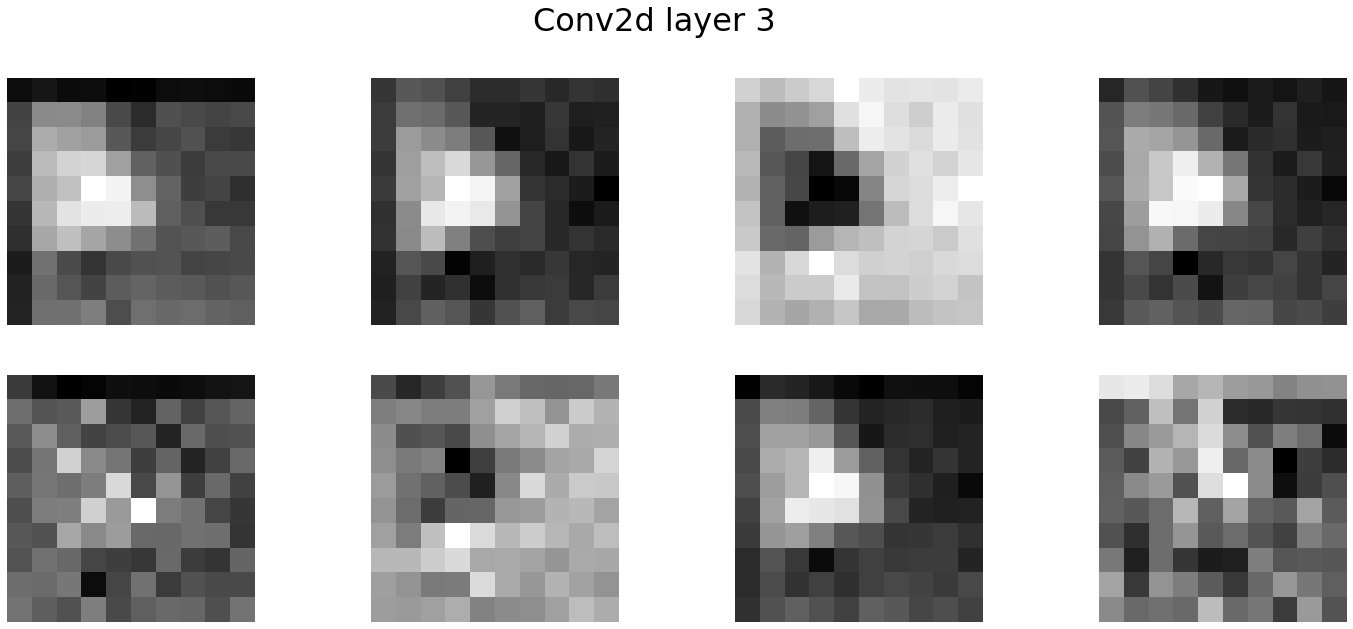

In [7]:
def findConvLayer(module, no_of_layers=0, conv_layers=None):
    if conv_layers is None: conv_layers=[]
    for child in list(module.children()):
        if type(child)==nn.Conv2d:
            no_of_layers+=1
            conv_layers.append(child)
        elif type(child)==nn.Sequential:
            no_of_layers, conv_layers = findConvLayer(child, no_of_layers, conv_layers)
    return no_of_layers, conv_layers

no_of_layers, conv_layers = findConvLayer(model)

print(no_of_layers)
print(conv_layers)

results = [conv_layers[0](tensor)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

for num_layer in range(len(outputs)):
    fig=plt.figure(figsize=(25, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    for i, filter in enumerate(layer_viz):
        if i == 8:
            break
        plt.subplot(2, 4, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    fig.suptitle(f"Conv2d layer {num_layer+1}", fontsize=32)
    plt.show()
    plt.close()

Feature maps visualization
https://androidkt.com/how-to-visualize-feature-maps-in-convolutional-neural-networks-using-pytorch/
Goal: to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps detect small or fine-grained detail.
The feature maps are a result of applying filters to input images. Feature maps output by prior layers could provide insight into the internal representation that the model has of a specific input at a given point in the model.